### Data Cleaning Lab — Python/Pandas (Market Data)

## Goals

In this lab we will:

- Diagnose data quality issues:
  - Missing values
  - Outliers
  - Type / formatting issues
- Apply imputation strategies:
  - Simple (global median / mode)
  - Group-wise or domain-based (if needed)
- Detect and treat outliers:
  - IQR-based capping
  - z-score based filtering (optional)
- Transform values:
  - Numeric (log transforms, feature scaling ideas)
  - Categorical (normalisation, rare category bucketing, one-hot encoding)
  - Datetime (feature extraction: year, month, day-of-week)
- Produce a brief data cleaning **report**:
  - Before/after metrics
  - Key decisions and their impact

**Dataset**: `market_data_dirty.csv`  
Synthetic market-style transactional data.


### 0) setting the environment - Directions

- We import the standard data science stack:
  - `pandas` for tabular data manipulation.
  - `numpy` for numerical operations.
  - `matplotlib.pyplot` for plotting.


In [58]:
# 0) Imports & global options

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



### 1) Load & Quick Profile — Directions

- We define three paths:
  - `market_data_dirty.csv`: raw input file.
  - `market_data_clean.csv`: output after cleaning.
- read the data file into dataframe `df` using the `read_csv` method of Pandas with appropriate parameters
  - `parse_dates=["timestamp"]` makes sure that the `timestamp` column is read directly as a `datetime64` column.
  - use `df.head()` First 5 rows

In [59]:
# 1) Load & Quick Profile

data_path = "market_data"
data_path_dirty = data_path + "_dirty.csv"
data_path_clean = data_path + "_clean.csv"

# Load the dirty data; parse timestamp as datetime
df = pd.read_csv(data_path_dirty, parse_dates=["timestamp"])


df.head(5)

,timestamp,store_id,product_id,city,channel,promo_flag,price,discount,units,temperature,stock,revenue
0,2024-01-01,106,1095,NaN,Online,0,10.39,0.129,2.0,NaN,50,17.49
1,2024-01-01,119,1021,Turin,Retail,0,NaN,0.334,8.0,24.8,32,109.77
2,2024-01-01,114,1067,rome,Online,1,31.62,0.303,12.0,14.1,40,256.02
3,2024-01-01,110,1068,NaN,Online,0,37.51,0.365,7.0,23.4,44,188.76
4,2024-01-01,107,1036,Naples,Retail,0,44.25,0.415,11.0,14.1,43,292.26


### 2: Explanation - Direction

- `df.info()` shows:
  - Number of rows and columns.
  - Data types of each column.
  - Non-null counts per column.
- From this we can quickly see:
  - Which columns have missing values (non-null count < total).
  - Type mismatches (e.g. numerical values stored as `object`).


In [60]:
# Basic info: structure and schema
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   timestamp    3000 non-null   datetime64[ns]
 1   store_id     3000 non-null   int64         
 2   product_id   3000 non-null   int64         
 3   city         2308 non-null   object        
 4   channel      3000 non-null   object        
 5   promo_flag   3000 non-null   int64         
 6   price        2833 non-null   float64       
 7   discount     2739 non-null   float64       
 8   units        2915 non-null   float64       
 9   temperature  2708 non-null   float64       
 10  stock        3000 non-null   int64         
 11  revenue      3000 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(4), object(2)
memory usage: 281.4+ KB


### 3: Numeric summary statistics - Direction

- `df.describe()` gives distribution statistics for numeric columns:
  - `count`, `mean`, `std`, `min`, `25%`, `50%`, `75%`, `max`.
- We look for:
  - Suspicious values (e.g. negative revenue, zero prices, extreme units).
  - Potential outliers (max values very far from median).
  - Range and scale of each variable.


In [61]:
# Numeric summary statistics
df.describe()

,timestamp,store_id,product_id,promo_flag,price,discount,units,temperature,stock,revenue
count,3000,3000.000000,3000.000000,3000.000000,2833.000000,2739.000000,2915.000000,2708.000000,3000.000000,3000.00000
mean,2024-04-09 03:40:48,109.354000,1049.625667,0.295000,29.875800,0.199218,10.193482,17.820532,49.421667,252.39424
min,2024-01-01 00:00:00,100.000000,1000.000000,0.000000,0.000000,0.004000,1.000000,-4.900000,0.000000,-808.76000
25%,2024-02-18 00:00:00,104.000000,1025.000000,0.000000,21.900000,0.107000,7.000000,13.300000,39.000000,134.86500
50%,2024-04-11 00:00:00,109.000000,1050.000000,0.000000,28.240000,0.181000,9.000000,17.900000,49.000000,204.21500
75%,2024-05-29 00:00:00,114.000000,1074.000000,1.000000,36.100000,0.272000,12.000000,22.700000,59.000000,293.02250
max,2024-07-18 00:00:00,119.000000,1099.000000,1.000000,85.640000,0.700000,270.000000,40.100000,100.000000,9584.74000
std,NaN,5.825804,28.534557,0.456119,11.299058,0.117273,10.974465,6.930652,15.127882,421.11270


### Column-wise missingness rates - Direction

- `df.isna().mean()` computes the **proportion of missing values** per column.
- We sort descending to see the **worst columns first**.
- This guides our missing value strategy:
  - High missingness columns may need special treatment (e.g. drop, or careful imputation).


In [62]:
# Column-wise missingness rates
na_rate = df.isna().mean().sort_values(ascending=True)
na_rate.head(15)

timestamp      0.000000
store_id       0.000000
product_id     0.000000
channel        0.000000
promo_flag     0.000000
revenue        0.000000
stock          0.000000
units          0.028333
price          0.055667
discount       0.087000
temperature    0.097333
city           0.230667
dtype: float64

### Starter Visualization - Directions

- We automatically identify:
  - `num_cols`: numeric columns (integers and floats).
  - `cat_cols`: non-numeric columns (strings, object types).
  - `dt_cols`: datetime columns.
- This is helpful to:
  - Apply numeric-only operations (e.g. histograms, correlations).
  - Apply categorical-specific cleaning (normalisation, encoding).
  - Extract time-based features from datetime columns.


In [63]:
# ===== Starter Visualizations =====

# --- Identify column types

num_cols = df.select_dtypes(include=np.number).columns.tolist() #This line finds all numeric columns in the DataFrame 
cat_cols = df.select_dtypes(exclude=np.number).columns.tolist() #This line identifies all non-numeric (categorical) columns 
dt_cols  = df.select_dtypes(include=["datetime64[ns]", "datetime64[ns, UTC]"]).columns.tolist() #This line finds datetime columns


print(num_cols)
print(cat_cols)
print(dt_cols)
    



['store_id', 'product_id', 'promo_flag', 'price', 'discount', 'units', 'temperature', 'stock', 'revenue']
['timestamp', 'city', 'channel']
['timestamp']


### Missingness per column - Directions

- We visualise missingness as a horizontal bar chart:
  - Y-axis: column names.
  - X-axis: proportion of missing values.
- This gives a **quick visual prioritisation**:
  - Which columns are clean.
  - Which ones need more attention.


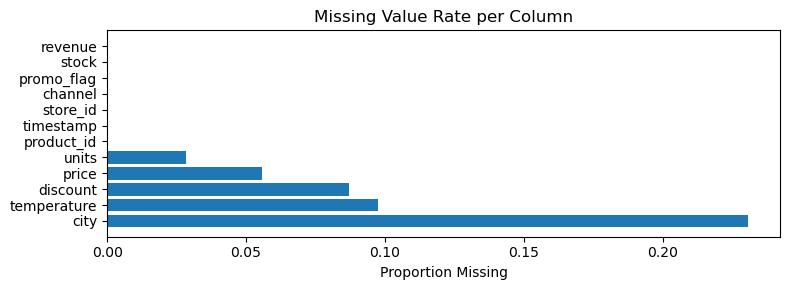

In [64]:
# --- Missingness per column
na_rate = df.isna().mean().sort_values(ascending=False)
plt.figure(figsize=(8, max(3, len(na_rate)*0.15)))
plt.barh(na_rate.index, na_rate.values)
plt.title("Missing Value Rate per Column")
plt.xlabel("Proportion Missing")
plt.tight_layout()
plt.show()

### Histograms for numeric columns - Directions

- Histograms show the **distribution shape** of each numeric column:
  - Skewness, heavy tails, multimodality.
- This helps:
  - Spot outliers visually (very large values).
  - Decide if log-transformations are reasonable.


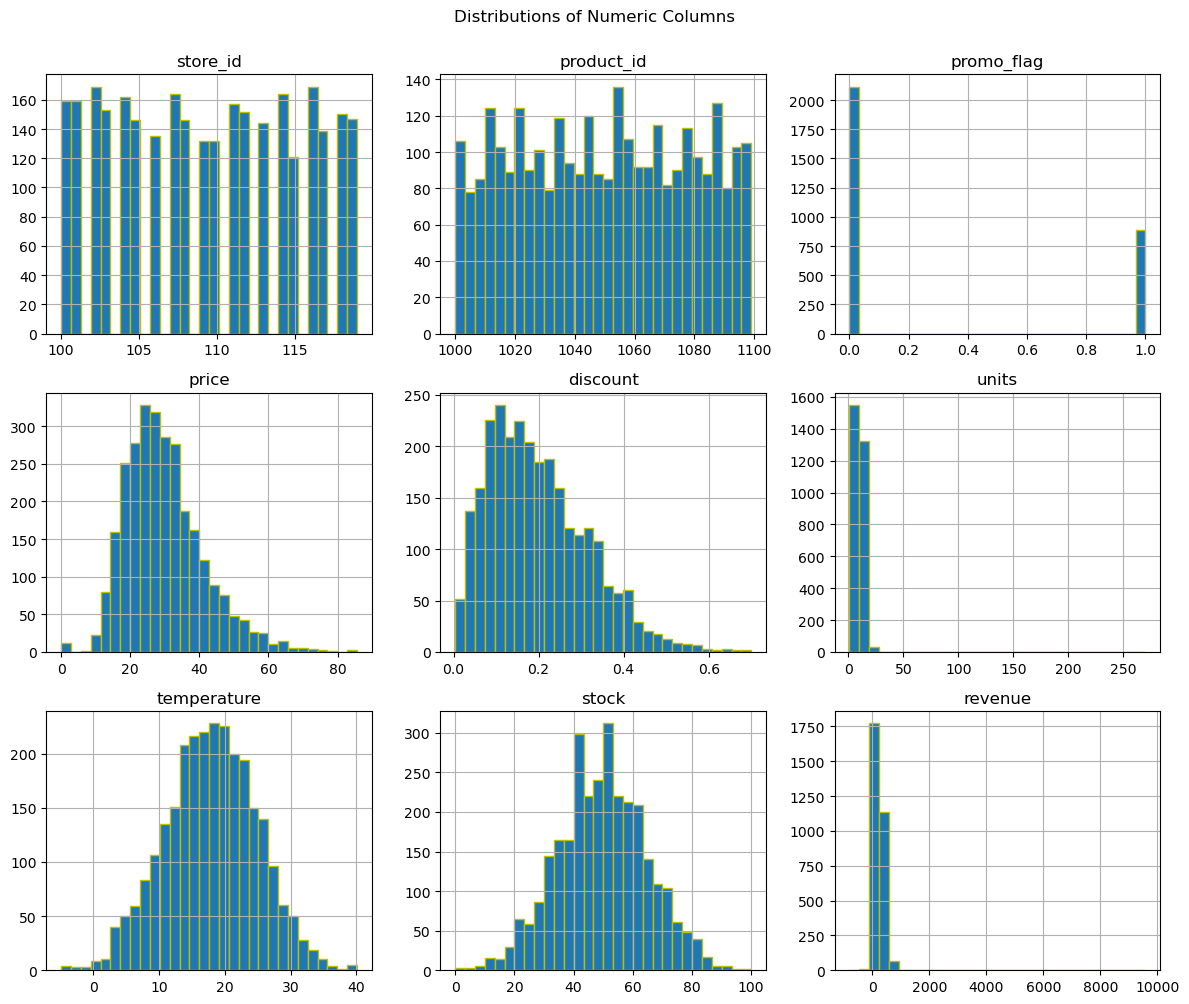

In [65]:
# --- Histograms for numeric columns
if num_cols:
    ax = df[num_cols].hist(bins=30, figsize=(12, 10), edgecolor="y")
    plt.suptitle("Distributions of Numeric Columns", y=1)
    plt.tight_layout()
    plt.show()


# Assistant
The selected code `edgecolor="y"` is a parameter used in the histogram plotting function that sets the color of the edges (borders) of each histogram bar to yellow. 

In Matplotlib, "y" is a shorthand color code for yellow. This parameter helps visually distinguish the boundaries between adjacent bars in the histogram, making the plot more readable by adding a yellow outline to each bar.

### Boxplots for key numeric columns (auto-pick top 6 by variance) - Direction

- We pick the numeric columns with the **highest variance**.
- Boxplots summarise these distributions using quartiles and whiskers:
  - Easy to see extreme values.
- This is a natural entry point for IQR-based outlier handling.


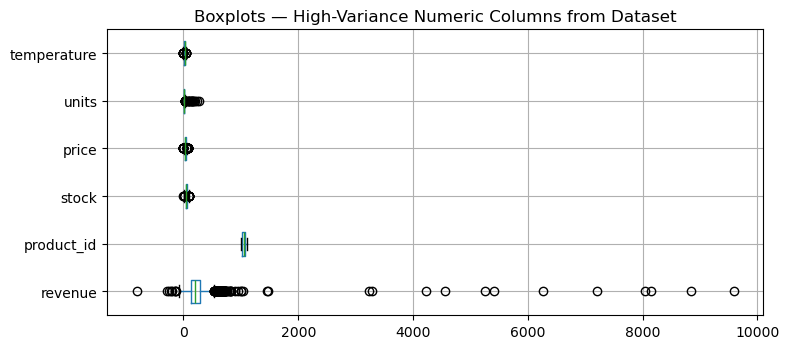

In [66]:
# Select up to 6 numeric columns with highest variance
top_cols = df[num_cols].var().nlargest(6).index

# Plot boxplots
df[top_cols].boxplot(vert= False, figsize=(8, max(3, len(top_cols)*0.6)))
plt.title("Boxplots — High-Variance Numeric Columns from Dataset")
plt.tight_layout()
plt.show()
    

### Bar charts for categorical columns (top 15 levels each) - Directions

- For each categorical column (up to 3):
  - We visualise the **top 15 categories** by frequency.
- This helps:
  - Detect rare categories (candidates for bucketing).
  - Spot inconsistent labelling (e.g. "milan" vs "Milan").


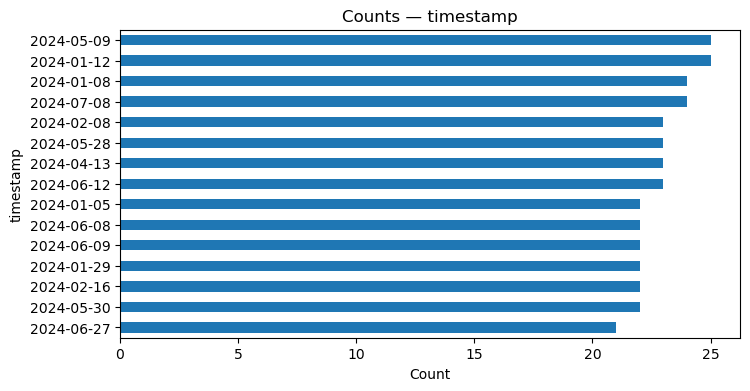

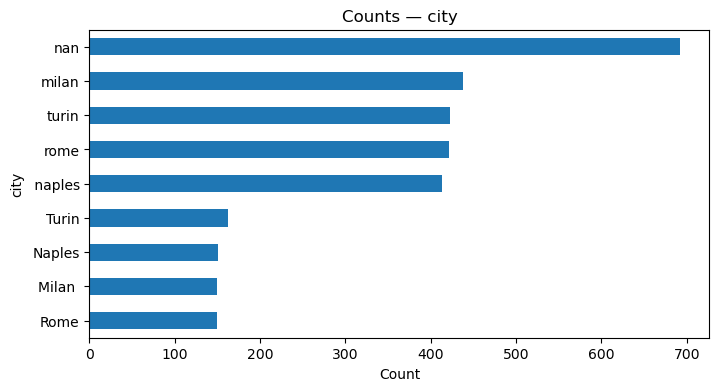

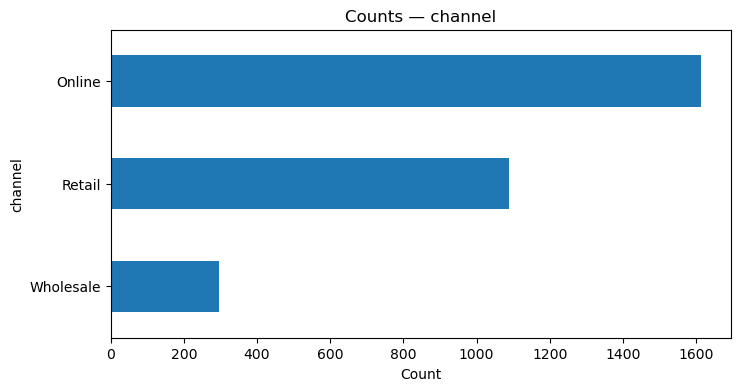

In [67]:
# --- Bar charts for categorical columns (top 15 levels each)

for col in cat_cols[:3]:
    df[col].astype(str).value_counts().head(15).sort_values().plot(
        kind="barh", figsize=(8, 4)
    )
    plt.title(f"Counts — {col}")
    plt.xlabel("Count")
    plt.show()


### Correlation heatmap for numeric columns - Directions

- The correlation heatmap:
  - Shows pairwise Pearson correlations between numeric variables.
- We use it to:
  - Spot relationships (e.g. `revenue` vs `units`).
  - Detect possible redundancy or multicollinearity.


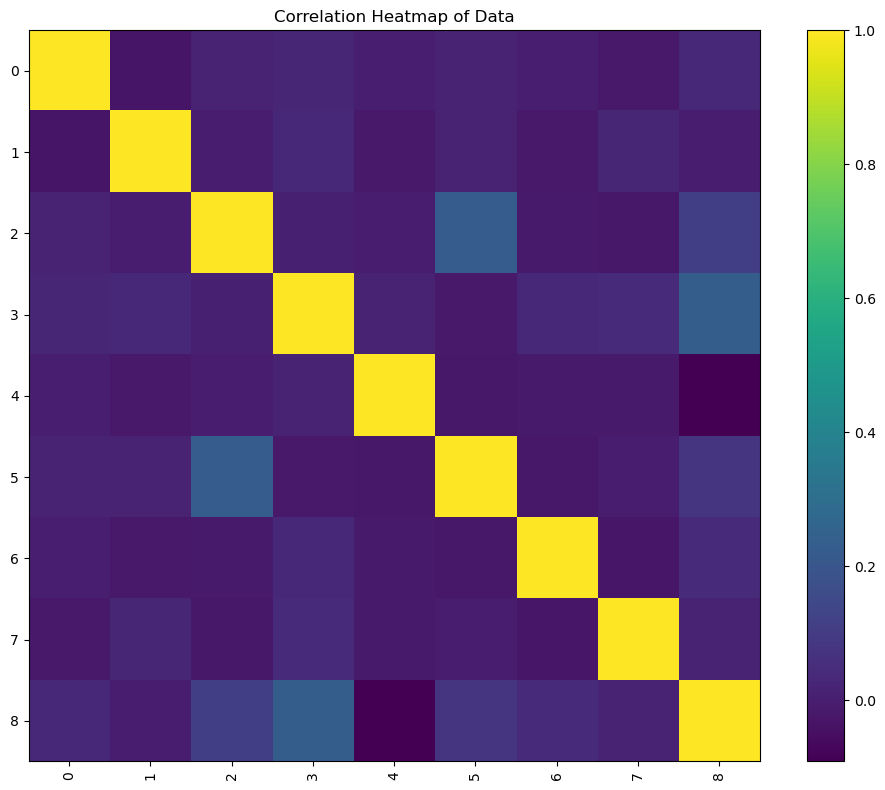

In [68]:
# --- Correlation heatmap for numeric columns
# --How can we add numbers in these boxes?
if len(num_cols) >= 2:
    plt.figure(figsize=(10, 8))
    plt.imshow(df[num_cols].corr())
    plt.colorbar()
    plt.title("Correlation Heatmap of Data")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


### Scatter matrix (small subset to avoid clutter) - Directions

- Scatter matrix plots give pairwise scatter plots between a subset of numeric features.
- The diagonal shows histograms.
- This is useful for:
  - Visual spotting of linear/non-linear relationships.
  - Detecting clusters or unusual patterns.


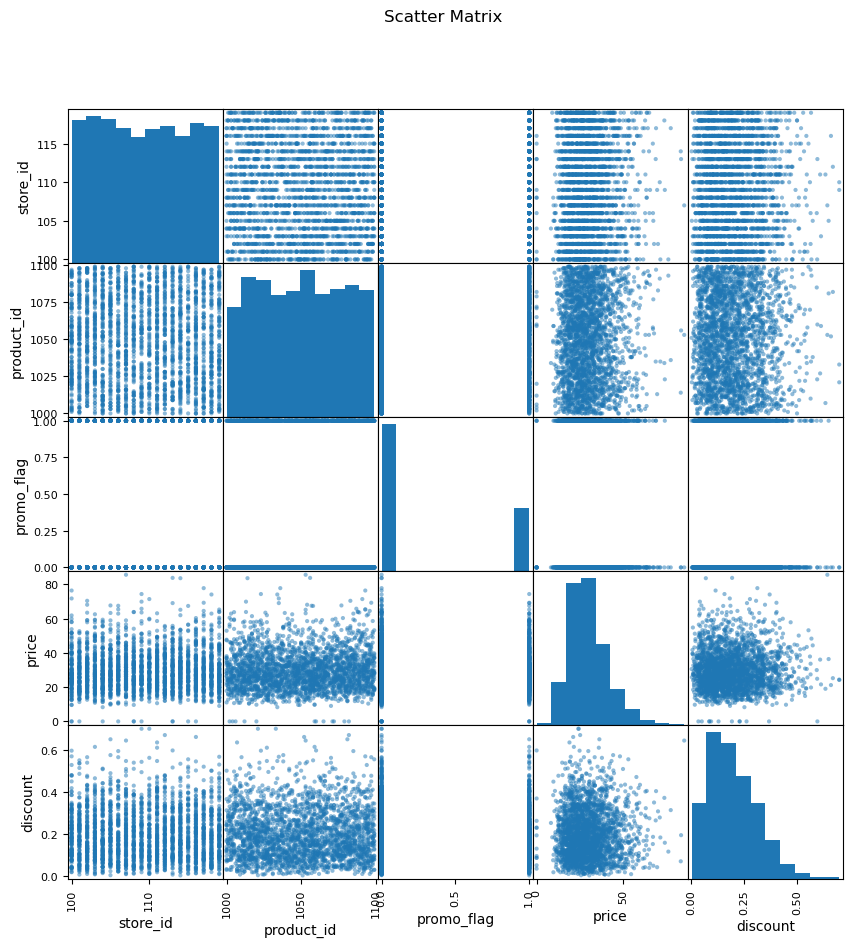

In [69]:
# --- Scatter matrix (small subset to avoid clutter)
from pandas.plotting import scatter_matrix
if len(num_cols) >= 2:
    scatter_matrix(df[num_cols[:5]].dropna(), figsize=(10, 10), diagonal="hist")
    plt.suptitle("Scatter Matrix")
    plt.show()


### Simple time series views if timestamp exists - directions

- We produce simple time series plots:
  - Daily count of records.
  - Daily sum of revenue.
- These help detect:
  - Gaps in data (days missing).
  - Sudden spikes or drops (potential anomalies).


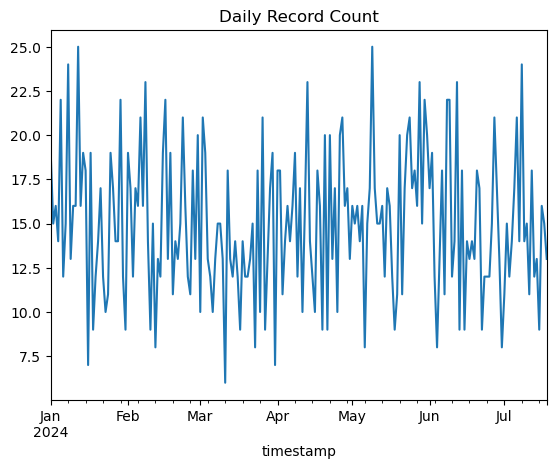

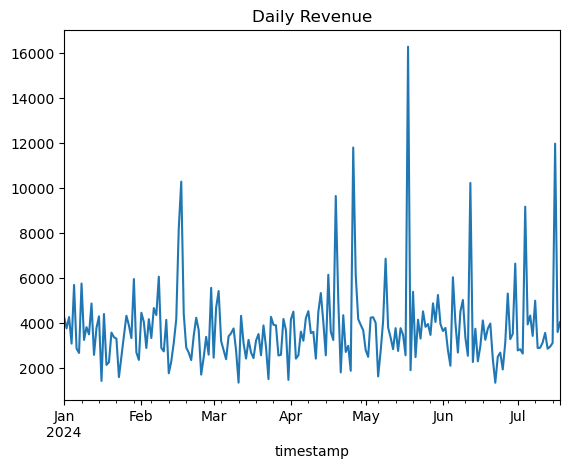

In [70]:
if "timestamp" in df.columns:
    df.set_index("timestamp").resample("D").size().plot(title="Daily Record Count")
    plt.show()

    if "revenue" in df.columns:
        df.set_index("timestamp")["revenue"].resample("D").sum().plot(title="Daily Revenue")
        plt.show()


### 2) Missing Values — Strategy Table (Plan)

We define a simple plan mapping **column → type → imputation strategy → rationale**.

| Column       | Type       | Strategy      | Rationale                                                                 |
|-------------|------------|---------------|---------------------------------------------------------------------------|
| `price`     | Numeric    | Median        | Robust to outliers, keeps typical price level.                            |
| `discount`  | Numeric    | Median        | Discount may have skew; median avoids extreme promotions dominating.      |
| `units`     | Numeric    | Median        | Orders are positive and skewed; median is stable and robust.             |
| `temperature` | Numeric  | Median        | Weather variations; median avoids bias from extremes.                     |
| `revenue`   | Numeric    | Median        | For missing values (if any), median keeps central tendency.              |
| `city`      | Categorical| Mode (most frequent) | Treat missing as “most typical city” to avoid creating spurious category. |
| `channel`   | Categorical| Mode          | Keep dominant sales channel as default.                                   |
| `promo_flag`| Numeric (0/1) | Mode       | Most common promotion status as default if missing.                       |
| `timestamp` | Datetime   | Already parsed; no missing | No action needed here (in this dataset).                         |

We also create **“was_missing” flag columns** for key variables so that models can later learn if a value was imputed.


In [71]:
# Recompute num & cat columns (for clarity)
print("Numeric:", df.select_dtypes(include="number").columns.tolist())
print("Categorical:", df.select_dtypes(exclude="number").columns.tolist())



Numeric: ['store_id', 'product_id', 'promo_flag', 'price', 'discount', 'units', 'temperature', 'stock', 'revenue']
Categorical: ['timestamp', 'city', 'channel']


### Flags BEFORE imputing if you want exact missingness - Directions

- For selected columns, we add binary flags like `price_was_missing`:
  - 1 = value was missing in original data.
  - 0 = value was present.
- Then we impute:
  - Numeric columns: fill missing values with **column median**.
  - Categorical columns: fill missing values with **mode** (most frequent value).
- We finally re-check missingness rates to confirm that:
  - All or most missing values have been handled.
  - NA rate is now ~0 for imputed columns.


In [72]:
# Flags BEFORE imputing if you want exact missingness
for col in ["price", "discount", "units", "temperature", "city"]:
    df[f"{col}_was_missing"] = df[col].isna().astype(int)

df[num_cols] = df[num_cols].fillna(df[num_cols].median())
df[cat_cols] = df[cat_cols].apply(lambda s: s.fillna(s.mode().iloc[0] if not s.mode().empty else "Unknown"))

df.isna().mean().sort_values(ascending=False).head(20)



timestamp                  0.0
store_id                   0.0
product_id                 0.0
city                       0.0
channel                    0.0
promo_flag                 0.0
price                      0.0
discount                   0.0
units                      0.0
temperature                0.0
stock                      0.0
revenue                    0.0
price_was_missing          0.0
discount_was_missing       0.0
units_was_missing          0.0
temperature_was_missing    0.0
city_was_missing           0.0
dtype: float64

### 3) Outliers — Plan

- We will focus on:
  - `revenue`, `units`, and `price` as key business metrics.
- We use two main approaches:
  1. IQR-based **capping** (winsorisation):
     - Clipping extreme values to lower/upper bounds.
  2. z-score-based **row dropping** (optional scenario):
     - Removing rows where values are extreme in standard deviation units.
- We compare:
  - Raw vs capped vs dropped datasets.


### Outliers — Plan - Directions

- `cap_iqr`:
  - Computes Q1, Q3 and IQR = Q3 − Q1.
  - Defines lower/upper bounds as `Q1 - 1.5*IQR` and `Q3 + 1.5*IQR`.
  - Clamps values outside this interval to the boundary.
- We look at the boxplots **before and after** capping:
  - Before: outliers appear as points beyond whiskers.
  - After: whiskers are shorter and extreme points are removed.
- This is a **conservative** way to make distributions more robust for models.


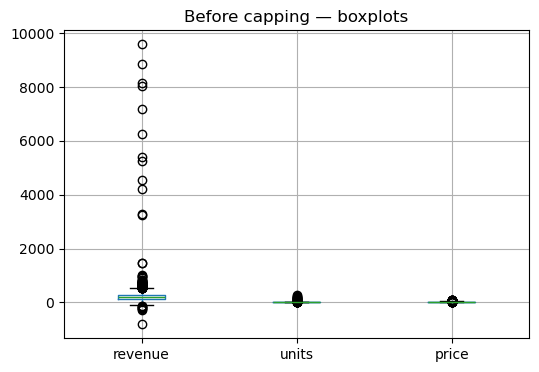

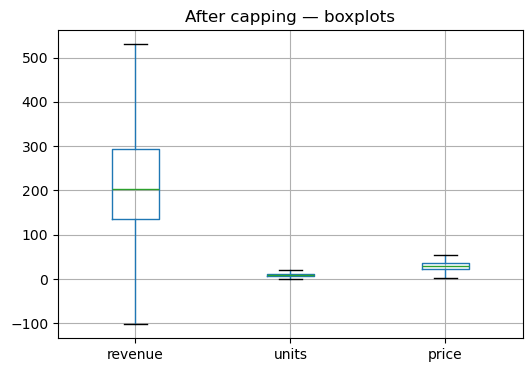

In [73]:
def cap_iqr(s, k=1.5):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    low, high = q1 - k*iqr, q3 + k*iqr
    return s.clip(lower=low, upper=high)

outlier_cols = ["revenue", "units", "price"]

# Boxplots before capping
df[outlier_cols].boxplot(figsize=(6,4))
plt.title("Before capping — boxplots")
plt.show()

# Apply IQR capping
df_cap = df.copy()
df_cap[outlier_cols] = df_cap[outlier_cols].apply(cap_iqr)

# Boxplots after capping
df_cap[outlier_cols].boxplot(figsize=(6,4))
plt.title("After capping — boxplots")
plt.show()


### z-score-based row drop (adjust threshold) - Directions

- `drop_outliers_z`:
  - For each chosen numeric column, computes the **z-score**.
  - Flags rows whose absolute z-score exceeds a threshold (default 3.5).
  - Drops all such rows.
- We compare dataset sizes:
  - `(3000, 2959)` means 41 rows were considered outliers and dropped.
- In practice:
  - **Capping** preserves all rows (less information loss).
  - **Dropping** is more aggressive but may help if extreme rows are clearly erroneous.


In [74]:
# Optional: z-score-based row drop (adjust threshold)
def drop_outliers_z(df_in, cols, z=3.5):
    zmask = np.zeros(len(df_in), dtype=bool)
    for c in cols:
        s = df_in[c]
        zc = (s - s.mean()) / s.std(ddof=0)
        zmask |= zc.abs() > z
    return df_in.loc[~zmask].copy()

df_drop = drop_outliers_z(df, outlier_cols, z=3.5)
len(df), len(df_drop)


(3000, 2959)

### 4) Transformations — Overview

We now apply feature transformations:

- **Categorical**:
  - Standardise city names (strip, title-case).
  - Replace placeholders such as `"N/A"` or empty strings with `"Unknown"`.
  - Bucket rare cities into an `"Other"` category.
  - One-hot encode the bucketed city variable.
- **Numeric**:
  - `log1p` transforms for `revenue` and `price` to stabilise variance.
- **Datetime**:
  - Extract `year`, `month`, and `day-of-week (dow)` from `timestamp`.


### Categorical cleanup- Direction

- `df["city"]` cleaning:
  - `.astype(str)` ensures consistent string type.
  - `.str.strip()` removes leading/trailing spaces.
  - `.str.title()` normalises case so `"milan"` and `"Milan"` become `"Milan"`.
  - `"N/A"` and `""` are mapped to `"Unknown"`.
- Rare categories:
  - We compute the **relative frequency** of each city.
  - Cities with frequency < 1% are grouped into `"Other"`.
- One-hot encoding:
  - We create dummy variables from `city_bucket`, dropping the first to avoid perfect multicollinearity.
- Numeric log transforms:
  - `np.log1p(x)` = `log(1 + x)` handles zero values safely.
  - This reduces the impact of very large values and makes distributions more symmetric.
- Datetime features:
  - `year`, `month`, `dow` capture seasonal patterns and weekly effects.


In [75]:
# --- Clean up city names
df["city"] = (
    df["city"]
      .astype("string")
      .str.strip()
      .str.title()
      .replace({"N/A": "Unknown", "": "Unknown"})
)

# --- Bucket rare cities (below 1% frequency)
threshold = 0.01
city_freq = df["city"].value_counts(normalize=True)
rare_cities = city_freq[city_freq < threshold].index

df["city_bucket"] = np.where(df["city"].isin(rare_cities), "Other", df["city"])

# One-hot encode the bucketed city
df = pd.get_dummies(df, columns=["city_bucket"], drop_first=True)

# --- Numeric log1p transforms
for col in ["revenue", "price"]:
    df[f"{col}_log1p"] = np.log1p(df[col].clip(lower=0))

# --- Datetime features
df["year"] = df["timestamp"].dt.year
df["month"] = df["timestamp"].dt.month
df["dow"] = df["timestamp"].dt.dayofweek

df.head()


,timestamp,store_id,product_id,city,channel,promo_flag,price,discount,units,temperature,stock,revenue,price_was_missing,discount_was_missing,units_was_missing,temperature_was_missing,city_was_missing,city_bucket_Naples,city_bucket_Rome,city_bucket_Turin,revenue_log1p,price_log1p,year,month,dow
0,2024-01-01,106,1095,Milan,Online,0,10.39,0.129,2.0,17.9,50,17.49,0,0,0,1,1,False,False,False,2.917230,2.432736,2024,1,0
1,2024-01-01,119,1021,Turin,Retail,0,28.24,0.334,8.0,24.8,32,109.77,1,0,0,0,0,False,False,True,4.707456,3.375538,2024,1,0
2,2024-01-01,114,1067,Rome,Online,1,31.62,0.303,12.0,14.1,40,256.02,0,0,0,0,0,False,True,False,5.549154,3.484926,2024,1,0
3,2024-01-01,110,1068,Milan,Online,0,37.51,0.365,7.0,23.4,44,188.76,0,0,0,0,1,False,False,False,5.245760,3.650918,2024,1,0
4,2024-01-01,107,1036,Naples,Retail,0,44.25,0.415,11.0,14.1,43,292.26,0,0,0,0,0,True,False,False,5.681060,3.812203,2024,1,0


### 5) Quality Report — Functions and Comparison

We define a simple quality metric function and compare:

- **Before cleaning** (raw dirty file).
- **After cleaning** (current `df`).

Metrics:

- Number of rows and columns.
- Mean NA rate across all columns.
- Count of negative `revenue` values.
- Count of zero `price` values.


### Directions

- `quality` summarises the dataset into a small one-row DataFrame of metrics.
- We explicitly reload `df_raw` to capture **pre-cleaning** statistics.
- By concatenating `q_before` and `q_after`, we can see:
  - Missingness reduction (ideally `na_rate_mean` decreases to 0).
  - Whether negative or zero values have been removed or remain.
- This acts as a **compact cleaning report**.


In [76]:
def quality(df):
    return pd.DataFrame({
        "rows": [len(df)],
        "cols": [df.shape[1]],
        "na_rate_mean": [df.isna().mean().mean()],
        "revenue_neg_count": [(df["revenue"] < 0).sum() if "revenue" in df else np.nan],
        "price_zero_count": [(df["price"] == 0).sum() if "price" in df else np.nan],
    })

# Reload raw data for baseline
df_raw = pd.read_csv(data_path_dirty, parse_dates=["timestamp"])

q_before = quality(df_raw).assign(stage="before_cleaning")
q_after  = quality(df).assign(stage="after_cleaning")

pd.concat([q_before, q_after], ignore_index=True)


,rows,cols,na_rate_mean,revenue_neg_count,price_zero_count,stage
0,3000,12,0.041583,10,12,before_cleaning
1,3000,25,0.000000,10,12,after_cleaning


### 6) `clean(df)` Pipeline — Workflow Description - Direction

The goal is to encapsulate our cleaning logic into a **single reusable function** `clean(df_in, ...)` that:

1. **Copies the input**  
   - Start with `d = df_in.copy()` to avoid modifying the caller’s DataFrame in place.

2. **Create missingness flags**  
   - For each column in `cols_w_missing`:
     - Add a new column `<col>_was_missing` (0/1).
     - This preserves information about where imputations occurred.

3. **Impute missing values**
   - Detect numeric columns via `d.select_dtypes(include=np.number)`.
   - Fill numeric NaNs with the **median** of each column.
   - For non-numeric columns:
     - Fill missing values with the **mode** (most frequent category), or `"Unknown"` if mode is empty.

4. **Outlier capping for selected numeric columns**
   - For each column in `cols_w_outliers`:
     - Compute Q1 and Q3 using `d[c].quantile([...])`.
     - Calculate IQR = Q3 − Q1.
     - Define lower/upper bounds: `Q1 − 1.5 * IQR`, `Q3 + 1.5 * IQR`.
     - Clip values outside bounds to the respective limit.
   - This applies an **IQR-based winsorisation** to stabilise the distributions.

5. **Categorical cleaning for `city`**
   - Standardise `city`:
     - Convert to string, strip whitespace, fix `"N/A"`, title-case, replace empty with `"Unknown"`.
   - Compute relative frequencies of each city.
   - Mark rare cities (frequency < 1%) and map them to `"Other"` via a new `city_bucket` column.

6. **One-hot encoding of `city_bucket`**
   - Apply `pd.get_dummies` to `city_bucket` with `drop_first=True`.
   - Produces binary indicator columns like `city_bucket_Rome`, `city_bucket_Naples`, etc.
   - Dropping the first category avoids perfect multicollinearity.

7. **Datetime feature extraction**
   - For `timestamp` (assumed datetime):
     - Extract:
       - `year` = calendar year.
       - `month` = month number (1–12).
       - `dow` = day of week (0=Monday, …, 6=Sunday).
   - These features can capture temporal patterns in models.

8. **Numeric transformations**
   - For revenue-related variables (e.g. `revenue`, `price`):
     - Apply `np.log1p` to non-negative values:
       - `revenue_log1p`, `price_log1p`.
     - This reduces skewness and makes the data more amenable to linear models.

9. **Optional datetime parsing**
   - If `parse_dates` is provided:
     - Convert those columns to datetime via `pd.to_datetime`.

10. **Return the cleaned DataFrame**
    - The function returns the fully transformed `d`.
    - Because we encapsulate all steps, we can:
      - Re-run cleaning on raw data easily.
      - Apply the same pipeline to new data in production.

In summary, `clean()` wraps:
- Missingness handling → outlier treatment → categorical normalisation → encoding → datetime features → numeric transforms  
into **one reproducible pipeline**.


In [77]:
#this is assignemnt for you all 
#you have to make the pipeline from starting andd then you have to start the work from begining

In [78]:
def clean(df_in,
          cols_w_missing=None,
          cols_w_outliers=None,
          top_quantile=0.25,
          bottom_quantile=0.75,
          parse_dates=None):
    """
    Clean a market_data-style DataFrame:
    - Add missingness flags
    - Impute numeric with median, categorical with mode
    - IQR-cap selected outlier columns
    - Normalise and encode 'city'
    - Add datetime features
    - Add log-transformed numeric features
    """

    d = df_in.copy()

    # Optional datetime parsing (if requested)
    if parse_dates is not None:
        for col in parse_dates:
            d[col] = pd.to_datetime(d[col])

    # 1) Missingness flags
    if cols_w_missing is not None:
        for c in cols_w_missing:
            d[f"{c}_was_missing"] = d[c].isna().astype(int)

    # 2) Impute numeric and categorical
    num = d.select_dtypes(include=np.number).columns
    d[num] = d[num].apply(lambda s: s.fillna(s.median()))

    for c in d.select_dtypes(exclude=np.number).columns:
        mode_vals = d[c].mode(dropna=True)
        d[c] = d[c].fillna(mode_vals[0] if not mode_vals.empty else "Unknown")

    # 3) Outlier cap (IQR) on selected columns
    if cols_w_outliers is not None:
        for c in cols_w_outliers:
            q1, q3 = d[c].quantile([top_quantile, bottom_quantile])
            iqr = q3 - q1
            low, high = q1 - 1.5 * iqr, q3 + 1.5 * iqr
            d[c] = d[c].clip(lower=low, upper=high)

    # 4) Categorical cleanup for city
    d["city"] = (d["city"]
                 .astype(str)
                 .str.strip()
                 .replace({"N/A": "Unknown"})
                 .str.title()
                 .replace({"": "Unknown"}))

    # 5) Rare bucket + one-hot for city
    freq = d["city"].value_counts(normalize=True)
    rare = freq[freq < 0.01].index
    d["city_bucket"] = d["city"].where(~d["city"].isin(rare), "Other")
    d = pd.get_dummies(d, columns=["city_bucket"], drop_first=True)

    # 6) Datetime features (assuming 'timestamp' is datetime)
    d["year"] = d["timestamp"].dt.year
    d["month"] = d["timestamp"].dt.month
    d["dow"] = d["timestamp"].dt.dayofweek

    # 7) Numeric transforms
    for c in ["revenue", "price"]:
        if c in d.columns:
            d[c + "_log1p"] = np.log1p(d[c].clip(lower=0))

    return d


In [79]:
def load_and_clean(path):
    df = pd.read_csv(path, parse_dates=["timestamp"])
    return clean(
        df,
        parse_dates=["timestamp"],
        cols_w_missing=["price", "discount", "units", "temperature", "city"],
        cols_w_outliers=["revenue", "units", "price"]
    )

df_clean = load_and_clean(data_path_dirty)
df_clean.head()


,timestamp,store_id,product_id,city,channel,promo_flag,price,discount,units,temperature,stock,revenue,price_was_missing,discount_was_missing,units_was_missing,temperature_was_missing,city_was_missing,city_bucket_Naples,city_bucket_Rome,city_bucket_Turin,year,month,dow,revenue_log1p,price_log1p
0,2024-01-01,106,1095,Milan,Online,0,10.39,0.129,2.0,17.9,50,17.49,0,0,0,1,1,False,False,False,2024,1,0,2.917230,2.432736
1,2024-01-01,119,1021,Turin,Retail,0,28.24,0.334,8.0,24.8,32,109.77,1,0,0,0,0,False,False,True,2024,1,0,4.707456,3.375538
2,2024-01-01,114,1067,Rome,Online,1,31.62,0.303,12.0,14.1,40,256.02,0,0,0,0,0,False,True,False,2024,1,0,5.549154,3.484926
3,2024-01-01,110,1068,Milan,Online,0,37.51,0.365,7.0,23.4,44,188.76,0,0,0,0,1,False,False,False,2024,1,0,5.245760,3.650918
4,2024-01-01,107,1036,Naples,Retail,0,44.25,0.415,11.0,14.1,43,292.26,0,0,0,0,0,True,False,False,2024,1,0,5.681060,3.812203


### 7) Exercises / Student Deliverables

Students should complete the following (the code above provides one reference solution):

1. **Missingness plan (table)**  
   - Recreate the column → type → strategy → rationale table for this dataset or a new one.

2. **Imputation implementation**
   - Compute NA% **before and after** imputation for each column.
   - Show a small summary table or bar plot.

3. **Outlier handling comparison**
   - For `revenue` and `units`, compare:
     - Raw distribution
     - IQR-capped distribution
     - Log-transformed distribution (`log1p`)
   - Use boxplots / histograms and **write a short commentary** on the effect.

4. **Categorical cleanup trade-offs**
   - Normalise `city`, bucket rare levels at 1% threshold, and one-hot encode.
   - Discuss:
     - Pros: fewer categories, more robust model.
     - Cons: some city-specific detail lost.

5. **Datetime features & seasonality**
   - Add `year`, `month`, `dow` (or reuse from the pipeline).
   - Produce a simple seasonal plot, e.g.:
     - Average revenue by `month`.
     - Average units by `dow`.

6. **Pipeline reproducibility**
   - Implement your own `clean(df)` or reuse the provided one.
   - Demonstrate:
     - Load raw data.
     - Call `clean(raw)`.
     - Show a small `quality` report before/after.

7. **Cleaning report (5–10 bullet points)**
   - Summarise:
     - Main issues found.
     - Choices made for missingness and outliers.
     - Key transformations.
     - Any remaining caveats or business assumptions.


In [80]:
# 8) Export cleaned data
df_clean.to_csv(data_path_clean, index=False)
print(f'Saved cleaned data to this place name "{data_path_clean}"')



Saved cleaned data to this place name "market_data_clean.csv"


### Explanation

- We save the cleaned dataset to `market_data_clean.csv`.
- This file is ready for:
  - EDA (exploratory data analysis).
  - Machine learning model training.
  - Sharing with other team members.
